In [2]:
import pandas as pd
import ast
pd.set_option('max_colwidth', 500)
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
import json
import re
import shap
import lightgbm as lgb
import itertools
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score,make_scorer

from utils.utils import *
from utils.pre_processing import *
from utils.nn import *
from utils.nn_utils import *
from utils.ml_utils import *

In [ ]:
datasets = create_dataset(oversampling=True,undersampling=True,no_sampling=True)
datasets

In [3]:
res_df = pd.read_csv('ml_model_results.csv')
res_df[[col for col in res_df.columns if 'Unnamed' not in col]].sort_values(['Val_Score'],ascending=False)#.head(3)

,Model,Sampling Technique,Hyperparameters,Test_Score,Val_Score
8,LightGBM,no_sampling,"{'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 200, 'num_leaves': 10, 'scale_pos_weight': 18}",0.192749,0.342857
4,RandomForest,undersampling,"{'max_depth': 50, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}",0.675495,0.230769
5,LightGBM,undersampling,"{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500, 'num_leaves': 20}",0.657875,0.198198
6,LogisticRegression,no_sampling,"{'C': 1, 'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'l2', 'solver': 'saga'}",0.111480,0.149378
0,LogisticRegression,oversampling,"{'C': 100, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}",0.865989,0.126697
3,LogisticRegression,undersampling,"{'C': 100, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}",0.549748,0.124424
7,RandomForest,no_sampling,"{'class_weight': 'balanced', 'max_depth': 5, 'min_samples_leaf': 6, 'min_samples_split': 10, 'n_estimators': 500}",0.102832,0.075472
1,RandomForest,oversampling,"{'max_depth': 50, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 500}",0.972918,0.028571
2,LightGBM,oversampling,"{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'num_leaves': 50}",0.983544,0.000000


In [4]:
winner = res_df.sort_values(['Val_Score'],ascending=False).reset_index(drop=True).iloc[0]
winner_model = winner['Model']
winner_sampling = winner['Sampling Technique']
winner_params = winner['Hyperparameters']

In [5]:
models = {
    'LogisticRegression': LogisticRegression,
    'RandomForest': RandomForestClassifier,
    'LightGBM': LGBMClassifier,
}

In [7]:
dataset = datasets[winner_sampling]
params = ast.literal_eval(winner_params)
model = models.get(winner_model)(**params)

x_train,y_train,x_val,y_val, x_test, y_test, df, scale_pos_weight = dataset['X_train'],dataset['y_train'],dataset['X_val'],dataset['y_val'],dataset['X_test'],dataset['y_test'],dataset['df'],dataset['scale_pos_weight']

In [8]:
model.fit(x_train, y_train, eval_set=[(x_val, y_val)], eval_metric='logloss')

[LightGBM] [Info] Number of positive: 150, number of negative: 2705
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 69557
[LightGBM] [Info] Number of data points in the train set: 2855, number of used features: 310
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.052539 -> initscore=-2.892222
[LightGBM] [Info] Start training from score -2.892222


LGBMClassifier(learning_rate=0.01, max_depth=10, n_estimators=200,
               num_leaves=10, scale_pos_weight=18)

In [9]:
# Predict on validation and test sets
y_val_pred = model.predict(x_val)
y_test_pred = model.predict(x_test)

# Calculate metrics
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)

test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

# Print the metrics
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Precision: {val_precision:.4f}")
print(f"Validation Recall: {val_recall:.4f}")
print(f"Validation F1 Score: {val_f1:.4f}")
print('\n')
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

Validation Accuracy: 0.9034
Validation Precision: 0.3396
Validation Recall: 0.3462
Validation F1 Score: 0.3429


Test Accuracy: 0.9082
Test Precision: 0.2000
Test Recall: 0.2609
Test F1 Score: 0.2264


In [10]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(x_train)

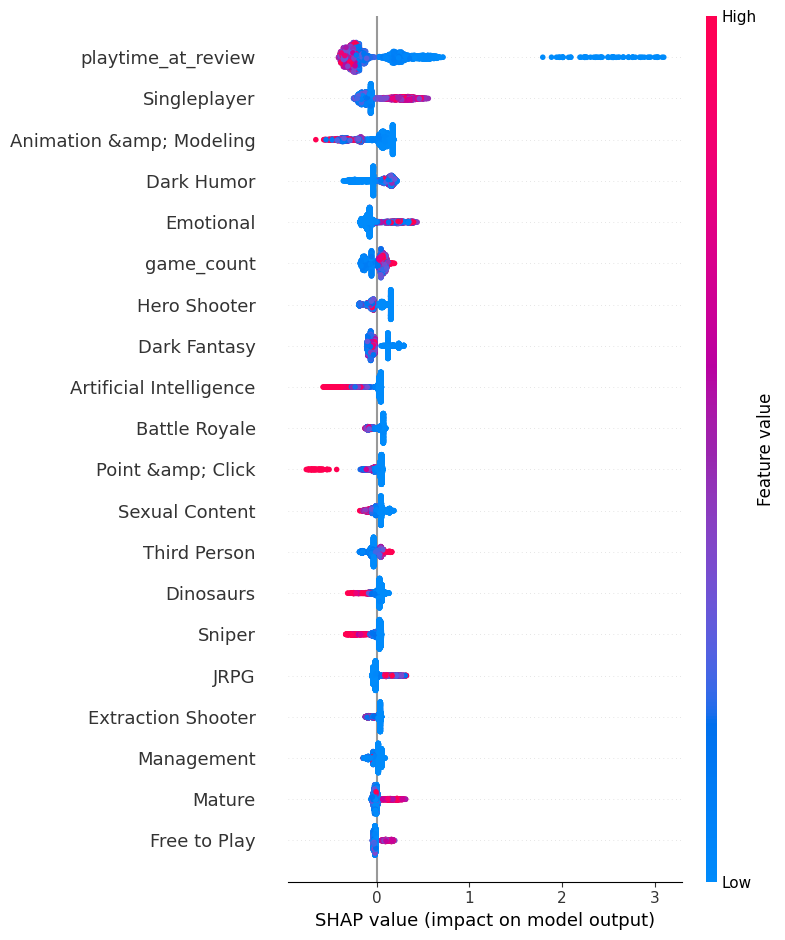

In [11]:
shap.summary_plot(shap_values, x_train, feature_names=df.columns[:-1],max_display=20)

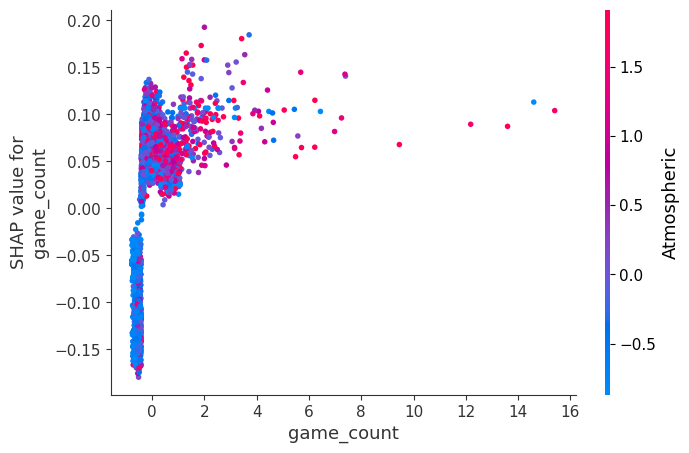

In [14]:
shap.dependence_plot('game_count', shap_values.values, x_train, feature_names=df.columns[:-1])

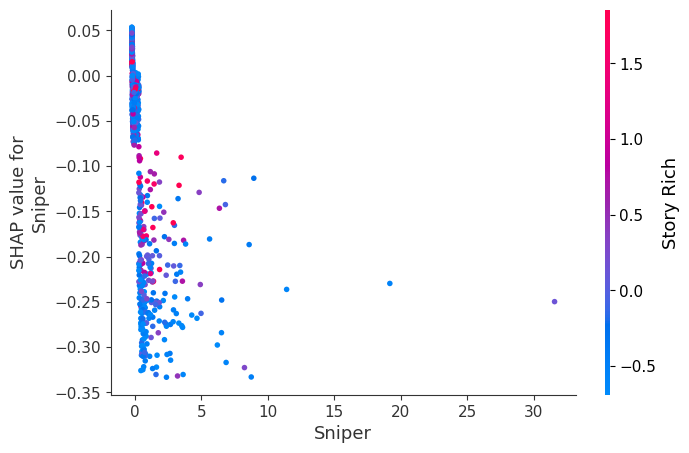

In [12]:
shap.dependence_plot('Sniper', shap_values.values, x_train, feature_names=df.columns[:-1])

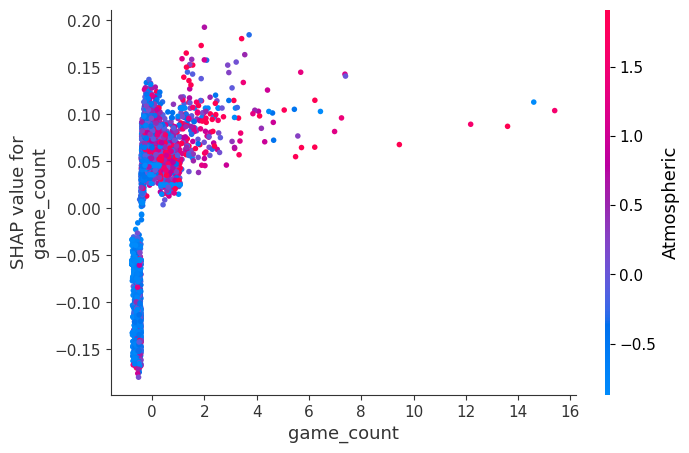

In [13]:
shap.dependence_plot('game_count', shap_values.values, x_train, feature_names=df.columns[:-1])